# Turtle Trading Project — Stage 08: Exploratory Data Analysis (EDA)

**Project:** Turtle Trading Strategy Development  
**Stage:** 08 - Exploratory Data Analysis  
**Author:** Panwei Hu  
**Date:** 2025-08-22

## Objectives
- Conduct comprehensive EDA on Turtle Trading financial data
- Analyze price patterns, volatility, and market behavior across ETF universe
- Examine relationships between financial indicators and trading signals
- Assess data quality and identify anomalies in financial time series
- Generate insights for Turtle Trading strategy optimization
- Document statistical properties of financial data for modeling

## Turtle Trading EDA Framework
- **Price Analysis**: Distribution patterns, volatility clustering, return characteristics
- **Technical Indicators**: Donchian channels, ATR, breakout patterns
- **Cross-Asset Analysis**: Correlations, sector relationships, diversification benefits
- **Time Series Properties**: Stationarity, autocorrelation, seasonal patterns
- **Risk Metrics**: VaR, drawdowns, tail risk, volatility regimes
- **Trading Signal Quality**: Breakout frequency, signal persistence, false signals

## Dataset Overview
- **Universe**: Diversified ETF portfolio (SPY, QQQ, IWM, EFA, EEM, VNQ, GLD, TLT, etc.)
- **Timeframe**: Multi-year daily OHLCV data
- **Features**: Price data + technical indicators + risk metrics
- **Source**: Previous stages (data acquisition → preprocessing → risk analysis)


In [2]:
# Setup and Imports
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Financial analysis libraries
try:
    import yfinance as yf
    import pandas_ta as ta
except ImportError:
    print("⚠️ Optional libraries not available")

# Import project utilities
try:
    from preprocessing import FinancialDataProcessor, TurtleDataCleaner
    from risk_analysis import FinancialOutlierDetector, TurtleRiskAnalyzer, FinancialRiskVisualizer
    print("✅ Successfully imported Turtle project utilities")
except ImportError as e:
    print(f"⚠️ Project utilities not available: {e}")

# Import homework EDA utilities
try:
    from eda_utils import (
        UnivariateAnalyzer,
        BivariateAnalyzer,
        EDAVisualizer,
        EDAReporter
    )
    print("✅ Successfully imported EDA utilities")
except ImportError as e:
    print(f"⚠️ EDA utilities not available: {e}")

# Configure plotting for financial data
plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10
np.random.seed(42)
pd.set_option('display.max_columns', 100)

print("🐢 TURTLE TRADING PROJECT - STAGE 08: EXPLORATORY DATA ANALYSIS")
print("="*80)


⚠️ Optional libraries not available
✅ Successfully imported Turtle project utilities
✅ Successfully imported EDA utilities
🐢 TURTLE TRADING PROJECT - STAGE 08: EXPLORATORY DATA ANALYSIS


In [ ]:
# Load Turtle Trading Data
print("📊 LOADING TURTLE TRADING DATASET")
print("="*50)

# Load the most recent preprocessed data
data_path = '../data/processed/'
try:
    # Load main preprocessed dataset
    df = pd.read_parquet(data_path + 'turtle_preprocessed_20250820_115449.parquet')
    print(f"✅ Loaded preprocessed data: {df.shape}")
    
    # Load risk analysis results
    risk_data = pd.read_csv(data_path + 'turtle_risk_metrics_20250821_120421.csv')
    print(f"✅ Loaded risk metrics: {risk_data.shape}")
    
    # Load outlier analysis
    outlier_data = pd.read_csv(data_path + 'turtle_outlier_analysis_20250821_120421.csv')
    print(f"✅ Loaded outlier analysis: {outlier_data.shape}")
    
except FileNotFoundError as e:
    print(f"⚠️ Main data files not found: {e}")
    # Fallback to available data
    try:
        df = pd.read_csv(data_path + 'turtle_real_data.csv', parse_dates=['date'])
        print(f"✅ Loaded fallback data: {df.shape}")
        risk_data = None
        outlier_data = None
    except FileNotFoundError:
        print("❌ No turtle data available")
        df = None

if df is not None:
    # Basic dataset info
    print(f"\n📋 Dataset Overview:")
    print(f"   Shape: {df.shape}")
    print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"   Assets: {df['symbol'].nunique() if 'symbol' in df.columns else 'Unknown'}")
    print(f"   Time periods: {len(df['date'].unique())}")
    
    # Display basic info
    print(f"\n📊 Column Information:")
    print(df.dtypes)
    
    print(f"\n🔍 Sample Data:")
    print(df.head())
    
    # Missing data assessment
    missing_data = df.isnull().sum()
    if missing_data.any():
        print(f"\n❓ Missing Data:")
        for col, missing_count in missing_data[missing_data > 0].items():
            missing_pct = (missing_count / len(df)) * 100
            print(f"   {col}: {missing_count} ({missing_pct:.1f}%)")
    else:
        print(f"\n✅ No missing data detected")
        
else:
    print("❌ Cannot proceed without data")

# Identify key columns for analysis
if df is not None:
    # Financial data columns
    price_cols = [col for col in df.columns if col in ['open', 'high', 'low', 'adj_close', 'adj_close']]
    volume_cols = [col for col in df.columns if col in ['volume']]
    
    # Technical indicator columns  
    technical_cols = [col for col in df.columns if any(indicator in col.lower() 
                     for indicator in ['donchian', 'atr', 'sma', 'ema', 'breakout', 'signal'])]
    
    # Return columns
    return_cols = [col for col in df.columns if 'return' in col.lower()]
    
    print(f"\n🏷️ Column Categories:")
    print(f"   Price columns: {price_cols}")
    print(f"   Volume columns: {volume_cols}")
    print(f"   Technical indicators: {technical_cols}")
    print(f"   Return columns: {return_cols}")
    
    # Define analysis columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"   Total numeric columns: {len(numeric_cols)}")
    
print(f"\n✅ Data loading completed!")


📊 LOADING TURTLE TRADING DATASET
✅ Loaded preprocessed data: (9036, 22)
✅ Loaded risk metrics: (18, 14)
✅ Loaded outlier analysis: (18, 8)

📋 Dataset Overview:
   Shape: (9036, 22)
   Date range: 2023-08-21 00:00:00 to 2025-08-20 00:00:00
   Assets: 18
   Time periods: 502

📊 Column Information:
date                datetime64[ns]
adj_close                  float64
symbol                      object
asset_category              object
returns                    float64
return_zscore              float64
is_anomaly                    bool
sma_20                     float64
sma_50                     float64
donchian_high_20           float64
donchian_low_20            float64
donchian_mid_20            float64
donchian_high_55           float64
donchian_low_55            float64
atr_20                     float64
price_position             float64
long_entry_20                 bool
short_entry_20                bool
long_exit_10                  bool
short_exit_10                 bool
vol

In [5]:
df.columns

Index(['date', 'adj_close', 'symbol', 'asset_category', 'returns',
       'return_zscore', 'is_anomaly', 'sma_20', 'sma_50', 'donchian_high_20',
       'donchian_low_20', 'donchian_mid_20', 'donchian_high_55',
       'donchian_low_55', 'atr_20', 'price_position', 'long_entry_20',
       'short_entry_20', 'long_exit_10', 'short_exit_10', 'volatility_20',
       'trend_strength'],
      dtype='object')

In [30]:
# Financial Data Quality Assessment
print("🔍 FINANCIAL DATA QUALITY ASSESSMENT")
print("="*60)

if df is not None:
    # Asset universe analysis
    if 'symbol' in df.columns:
        asset_stats = df.groupby('symbol').agg({
            'date': ['count', 'min', 'max'],
            'adj_close': ['mean', 'std', 'min', 'max']
        }).round(3)
        
        print("📈 Asset Universe Analysis:")
        print(f"   Total assets: {df['symbol'].nunique()}")
        print(f"   Assets: {sorted(df['symbol'].unique())}")
        
        # Check for data completeness across assets
        date_counts = df.groupby('symbol')['date'].count()
        print(f"\n📅 Data Completeness by Asset:")
        print(f"   Expected observations per asset: {df['date'].nunique()}")
        print(f"   Actual observations range: {date_counts.min()} to {date_counts.max()}")
        
        incomplete_assets = date_counts[date_counts < date_counts.max()]
        if len(incomplete_assets) > 0:
            print(f"   ⚠️ Assets with missing data: {len(incomplete_assets)}")
            for asset, count in incomplete_assets.items():
                missing_pct = (1 - count/date_counts.max()) * 100
                print(f"     {asset}: {count} obs ({missing_pct:.1f}% missing)")
        else:
            print(f"   ✅ All assets have complete data")
    
    # Price data validation
    print(f"\n💰 Price Data Validation:")
    
    if 'adj_close' in df.columns:
        # Check for negative or zero prices
        invalid_prices = df[df['adj_close'] <= 0]
        if len(invalid_prices) > 0:
            print(f"   ❌ Invalid prices found: {len(invalid_prices)} records")
        else:
            print(f"   ✅ All prices are positive")
        
        if 'daily_return' not in df.columns:
            df['daily_return'] = df['adj_close'].pct_change()
            print("📈 Calculated daily returns")
        
        # Check for extreme price movements (>50% daily change)
        if 'daily_return' in df.columns:
            extreme_moves = df[abs(df['daily_return']) > 0.5]
            if len(extreme_moves) > 0:
                print(f"   ⚠️ Extreme daily moves (>50%): {len(extreme_moves)} records")
                print(f"     Max daily return: {df['daily_return'].max():.1%}")
                print(f"     Min daily return: {df['daily_return'].min():.1%}")
            else:
                print(f"   ✅ No extreme daily moves detected")
    
    # Volume analysis
    if 'volume' in df.columns:
        zero_volume = df[df['volume'] == 0]
        print(f"\n📊 Volume Analysis:")
        print(f"   Zero volume days: {len(zero_volume)} ({len(zero_volume)/len(df)*100:.1f}%)")
        print(f"   Average daily volume: {df['volume'].mean():,.0f}")
        print(f"   Volume range: {df['volume'].min():,.0f} to {df['volume'].max():,.0f}")
    
    # Time series continuity
    print(f"\n📅 Time Series Analysis:")
    if 'date' in df.columns:
        df_sorted = df.sort_values('date')
        date_diff = df_sorted['date'].diff()
        
        # Check for gaps (assuming daily data)
        expected_freq = pd.Timedelta(days=1)
        gaps = date_diff[date_diff > expected_freq * 3]  # More than 3 days gap
        
        print(f"   Date range: {df['date'].min().date()} to {df['date'].max().date()}")
        print(f"   Total trading days: {df['date'].nunique()}")
        print(f"   Calendar days: {(df['date'].max() - df['date'].min()).days}")
        
        if len(gaps) > 0:
            print(f"   ⚠️ Data gaps detected: {len(gaps)} instances")
        else:
            print(f"   ✅ No significant data gaps")
    
    # Technical indicator validation
    if technical_cols:
        print(f"\n🔧 Technical Indicators Validation:")
        for col in technical_cols[:5]:  # Check first 5 indicators
            null_count = df[col].isnull().sum()
            if null_count > 0:
                print(f"   {col}: {null_count} nulls ({null_count/len(df)*100:.1f}%)")
            else:
                print(f"   ✅ {col}: Complete data")
    
    # Data quality score
    quality_issues = 0
    if 'symbol' in df.columns and len(incomplete_assets) > 0:
        quality_issues += 1
    if 'adj_close' in df.columns and len(invalid_prices) > 0:
        quality_issues += 1
    if 'volume' in df.columns and len(zero_volume) > len(df) * 0.05:  # >5% zero volume
        quality_issues += 1
    
    print(f"\n🏆 Data Quality Assessment:")
    if quality_issues == 0:
        print(f"   ✅ EXCELLENT - No major quality issues detected")
    elif quality_issues <= 2:
        print(f"   ⚠️ GOOD - {quality_issues} minor issues detected")
    else:
        print(f"   ❌ POOR - {quality_issues} major issues require attention")

else:
    print("❌ No data available for quality assessment")

print(f"\n✅ Data quality assessment completed!")


🔍 FINANCIAL DATA QUALITY ASSESSMENT
📈 Asset Universe Analysis:
   Total assets: 18
   Assets: ['DBA', 'EEM', 'EFA', 'FXE', 'FXY', 'GLD', 'HYG', 'IEF', 'IWM', 'LQD', 'QQQ', 'SLV', 'SPY', 'TLT', 'UNG', 'USO', 'UUP', 'VEA']

📅 Data Completeness by Asset:
   Expected observations per asset: 502
   Actual observations range: 502 to 502
   ✅ All assets have complete data

💰 Price Data Validation:
   ✅ All prices are positive
📈 Calculated daily returns
   ⚠️ Extreme daily moves (>50%): 12 records
     Max daily return: 1150.0%
     Min daily return: -96.2%

📅 Time Series Analysis:
   Date range: 2023-08-21 to 2025-08-20
   Total trading days: 502
   Calendar days: 730
   ⚠️ Data gaps detected: 13 instances

🔧 Technical Indicators Validation:
   sma_20: 342 nulls (3.8%)
   sma_50: 882 nulls (9.8%)
   donchian_high_20: 342 nulls (3.8%)
   donchian_low_20: 342 nulls (3.8%)
   donchian_mid_20: 342 nulls (3.8%)

🏆 Data Quality Assessment:
   ✅ EXCELLENT - No major quality issues detected

✅ Data q

📊 PRICE AND RETURN DISTRIBUTION ANALYSIS
🎯 Analyzing primary asset: SPY


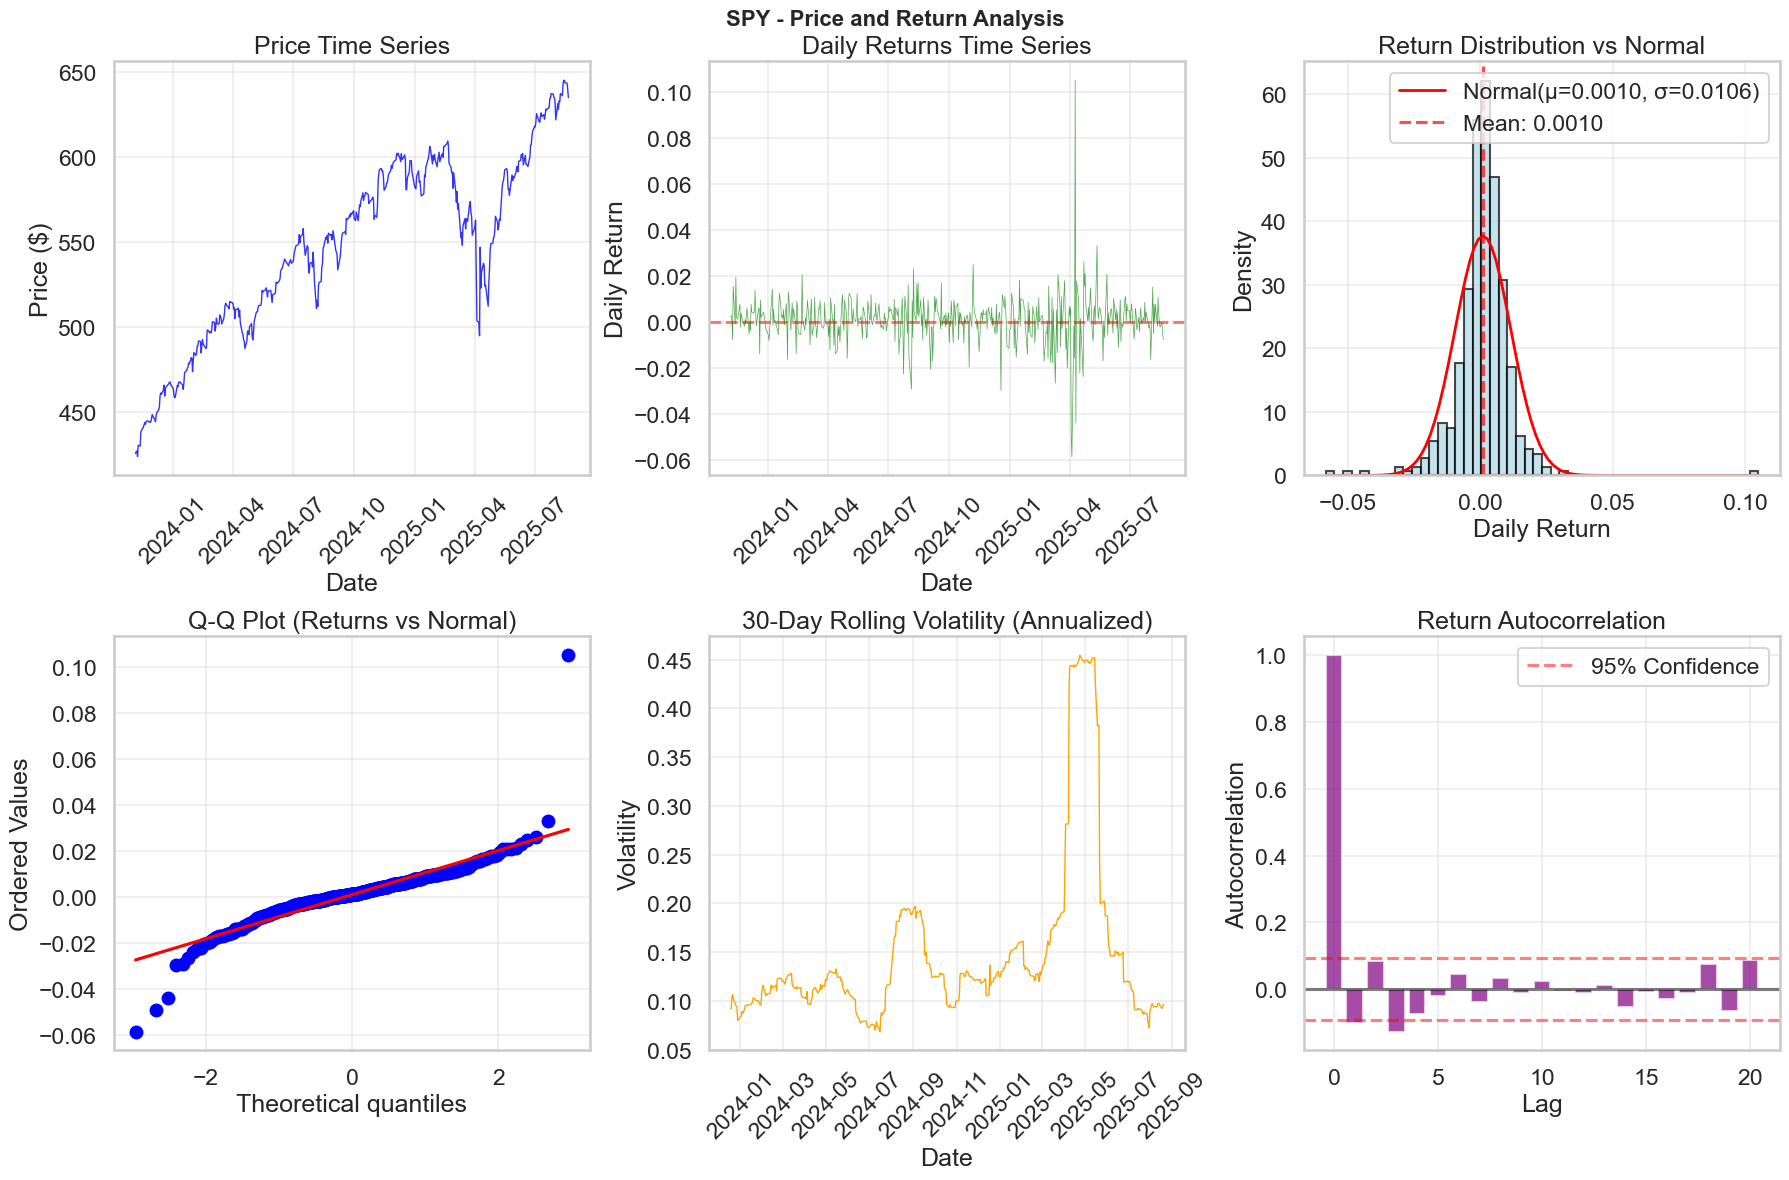


📈 Statistical Summary for SPY:
   Price Statistics:
     Mean: $546.44
     Std: $52.51
     Range: $424.08 - $644.95

   Return Statistics:
     Mean: 0.0010 (23.99% annualized)
     Std: 0.0106 (16.80% annualized)
     Skewness: 1.194
     Kurtosis: 23.849
     Min: -0.0585
     Max: 0.1050

   Normality Tests:
     Shapiro-Wilk: W=0.8241, p=0.0000
     Jarque-Bera: JB=10723.7532, p=0.0000
     Normal distribution: ❌ Rejected

   Volatility Clustering:
     Squared returns lag-1 autocorr: 0.2037
     ARCH effects: ✅ Present

✅ Price and return analysis completed!


In [31]:
# Price and Return Distribution Analysis
print("📊 PRICE AND RETURN DISTRIBUTION ANALYSIS")
print("="*60)

if df is not None and 'adj_close' in df.columns:
    # Focus on a key asset for detailed analysis (e.g., SPY)
    if 'symbol' in df.columns:
        primary_asset = 'SPY' if 'SPY' in df['symbol'].unique() else df['symbol'].unique()[0]
        asset_data = df[df['symbol'] == primary_asset].copy().sort_values('date')
        print(f"🎯 Analyzing primary asset: {primary_asset}")
    else:
        asset_data = df.copy()
        primary_asset = "Portfolio"
    
    # Calculate returns if not available
    if 'daily_return' not in asset_data.columns and 'adj_close' in asset_data.columns:
        asset_data['daily_return'] = asset_data['adj_close'].pct_change()
        print("📈 Calculated daily returns")
    
    asset_data.dropna(inplace=True)
    # Price analysis
    prices = asset_data['adj_close']
    returns = asset_data['daily_return']
    
    # Create comprehensive price/return distribution plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{primary_asset} - Price and Return Analysis', fontsize=16, fontweight='bold')
    
    # 1. Price time series
    ax1 = axes[0, 0]
    ax1.plot(asset_data['date'], prices, linewidth=1, alpha=0.8, color='blue')
    ax1.set_title('Price Time Series')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Return time series
    ax2 = axes[0, 1]
    ax2.plot(asset_data['date'], returns, linewidth=0.5, alpha=0.7, color='green')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_title('Daily Returns Time Series')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Return')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Return distribution
    ax3 = axes[0, 2]
    ax3.hist(returns, bins=50, alpha=0.7, density=True, edgecolor='black', color='lightblue')
    # Overlay normal distribution
    mu, sigma = returns.mean(), returns.std()
    x = np.linspace(returns.min(), returns.max(), 100)
    normal_dist = stats.norm.pdf(x, mu, sigma)
    ax3.plot(x, normal_dist, 'r-', linewidth=2, label=f'Normal(μ={mu:.4f}, σ={sigma:.4f})')
    ax3.axvline(returns.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {returns.mean():.4f}')
    ax3.set_title('Return Distribution vs Normal')
    ax3.set_xlabel('Daily Return')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Q-Q plot for normality
    ax4 = axes[1, 0]
    stats.probplot(returns, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Returns vs Normal)')
    ax4.grid(True, alpha=0.3)
    
    # 5. Rolling volatility
    ax5 = axes[1, 1]
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # Annualized
    ax5.plot(asset_data['date'], rolling_vol, linewidth=1, color='orange')
    ax5.set_title('30-Day Rolling Volatility (Annualized)')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('Volatility')
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Return autocorrelation
    ax6 = axes[1, 2]
    from statsmodels.tsa.stattools import acf
    lags = 20
    autocorr = acf(returns.dropna(), nlags=lags, fft=True)
    ax6.bar(range(lags+1), autocorr, alpha=0.7, color='purple')
    ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax6.axhline(y=1.96/np.sqrt(len(returns)), color='red', linestyle='--', alpha=0.5, label='95% Confidence')
    ax6.axhline(y=-1.96/np.sqrt(len(returns)), color='red', linestyle='--', alpha=0.5)
    ax6.set_title('Return Autocorrelation')
    ax6.set_xlabel('Lag')
    ax6.set_ylabel('Autocorrelation')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n📈 Statistical Summary for {primary_asset}:")
    print(f"   Price Statistics:")
    print(f"     Mean: ${prices.mean():.2f}")
    print(f"     Std: ${prices.std():.2f}")
    print(f"     Range: ${prices.min():.2f} - ${prices.max():.2f}")
    
    print(f"\n   Return Statistics:")
    print(f"     Mean: {returns.mean():.4f} ({returns.mean()*252:.2%} annualized)")
    print(f"     Std: {returns.std():.4f} ({returns.std()*np.sqrt(252):.2%} annualized)")
    print(f"     Skewness: {skew(returns):.3f}")
    print(f"     Kurtosis: {kurtosis(returns):.3f}")
    print(f"     Min: {returns.min():.4f}")
    print(f"     Max: {returns.max():.4f}")
    
    # Normality tests
    shapiro_stat, shapiro_p = stats.shapiro(returns[:5000])  # Limit for Shapiro-Wilk
    jb_stat, jb_p = jarque_bera(returns)
    
    print(f"\n   Normality Tests:")
    print(f"     Shapiro-Wilk: W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
    print(f"     Jarque-Bera: JB={jb_stat:.4f}, p={jb_p:.4f}")
    print(f"     Normal distribution: {'❌ Rejected' if min(shapiro_p, jb_p) < 0.05 else '✅ Not rejected'}")
    
    # Volatility clustering test (ARCH effect)
    squared_returns = returns**2
    arch_autocorr = acf(squared_returns.dropna(), nlags=5, fft=True)[1]  # Lag 1 autocorr
    print(f"\n   Volatility Clustering:")
    print(f"     Squared returns lag-1 autocorr: {arch_autocorr:.4f}")
    print(f"     ARCH effects: {'✅ Present' if arch_autocorr > 0.1 else '❌ Weak'}")

else:
    print("❌ Cannot perform price analysis - missing data")

print(f"\n✅ Price and return analysis completed!")


In [28]:
asset_data.columns

Index(['date', 'adj_close', 'symbol', 'asset_category', 'returns',
       'return_zscore', 'is_anomaly', 'sma_20', 'sma_50', 'donchian_high_20',
       'donchian_low_20', 'donchian_mid_20', 'donchian_high_55',
       'donchian_low_55', 'atr_20', 'price_position', 'long_entry_20',
       'short_entry_20', 'long_exit_10', 'short_exit_10', 'volatility_20',
       'trend_strength', 'daily_return'],
      dtype='object')

In [25]:
len(asset_data)

448

In [29]:
df.columns

Index(['date', 'adj_close', 'symbol', 'asset_category', 'returns',
       'return_zscore', 'is_anomaly', 'sma_20', 'sma_50', 'donchian_high_20',
       'donchian_low_20', 'donchian_mid_20', 'donchian_high_55',
       'donchian_low_55', 'atr_20', 'price_position', 'long_entry_20',
       'short_entry_20', 'long_exit_10', 'short_exit_10', 'volatility_20',
       'trend_strength'],
      dtype='object')

In [11]:
asset_data.dropna(inplace=True)

🔗 CROSS-ASSET CORRELATION ANALYSIS


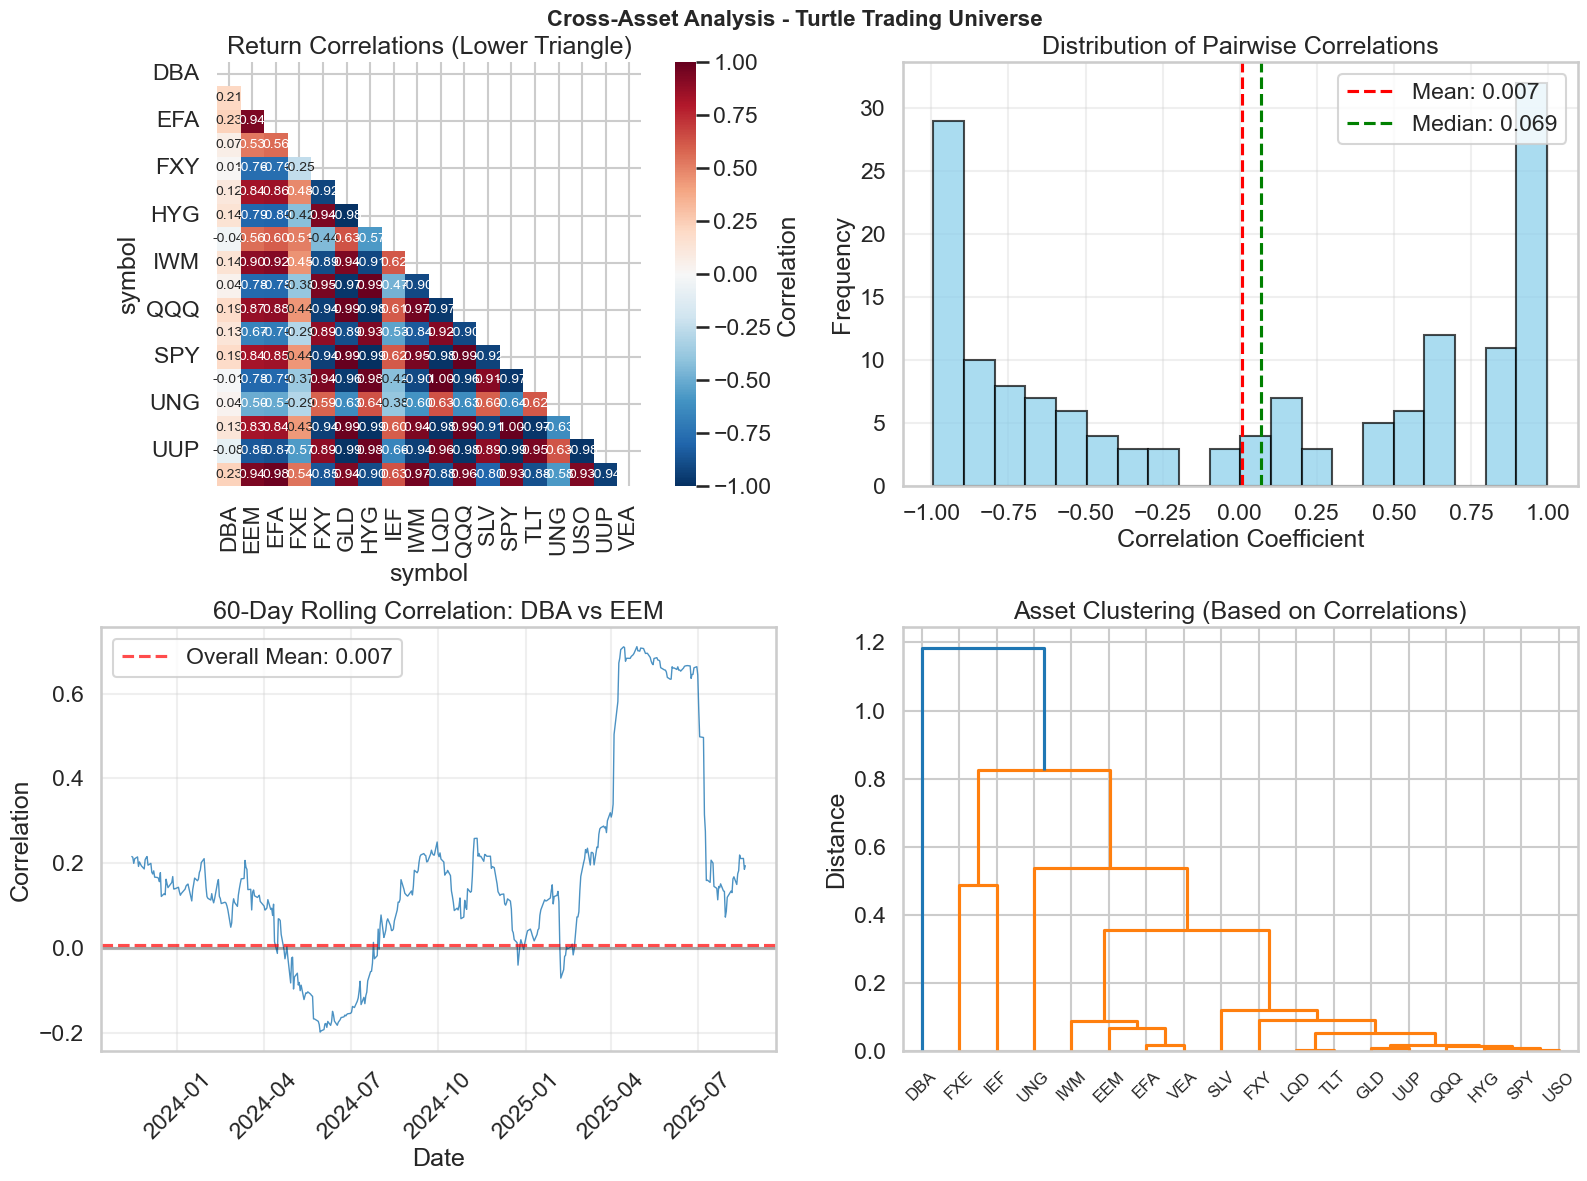


📊 Correlation Statistics:
   Number of asset pairs: 153
   Mean correlation: 0.007
   Median correlation: 0.069
   Std correlation: 0.768
   Min correlation: -0.993
   Max correlation: 0.997

🎯 Highly Correlated Pairs (|r| > 0.7):
   SPY ↔ USO: r = 0.997
   LQD ↔ TLT: r = 0.995
   QQQ ↔ SPY: r = 0.994
   HYG ↔ SPY: r = -0.993
   GLD ↔ SPY: r = 0.992
   GLD ↔ USO: r = 0.991
   HYG ↔ LQD: r = 0.991
   HYG ↔ USO: r = -0.991
   QQQ ↔ USO: r = 0.990
   GLD ↔ UUP: r = -0.990
   SPY ↔ UUP: r = -0.988
   GLD ↔ QQQ: r = 0.985
   GLD ↔ HYG: r = -0.985
   USO ↔ UUP: r = -0.984
   QQQ ↔ UUP: r = -0.981
   EFA ↔ VEA: r = 0.981
   LQD ↔ SPY: r = -0.981
   LQD ↔ USO: r = -0.980
   HYG ↔ UUP: r = 0.980
   HYG ↔ TLT: r = 0.978
   HYG ↔ QQQ: r = -0.978
   TLT ↔ USO: r = -0.970
   SPY ↔ TLT: r = -0.970
   GLD ↔ LQD: r = -0.969
   LQD ↔ QQQ: r = -0.967
   IWM ↔ VEA: r = 0.966
   IWM ↔ QQQ: r = 0.966
   LQD ↔ UUP: r = 0.960
   QQQ ↔ TLT: r = -0.960
   GLD ↔ TLT: r = -0.958
   QQQ ↔ VEA: r = 0.955
   IWM ↔

In [32]:
# Cross-Asset Correlation Analysis
print("🔗 CROSS-ASSET CORRELATION ANALYSIS")
print("="*50)

if df is not None and 'symbol' in df.columns and 'adj_close' in df.columns:
    # Create returns matrix for correlation analysis
    returns_pivot = df.pivot(index='date', columns='symbol', values='daily_return')
    
    if returns_pivot.shape[1] > 1:
        # Calculate correlation matrix
        corr_matrix = returns_pivot.corr()
        
        # Create comprehensive correlation visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Cross-Asset Analysis - Turtle Trading Universe', fontsize=16, fontweight='bold')
        
        # 1. Correlation heatmap
        ax1 = axes[0, 0]
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                   cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                   square=True, ax=ax1, cbar_kws={'label': 'Correlation'})
        ax1.set_title('Return Correlations (Lower Triangle)')
        
        # 2. Correlation distribution
        ax2 = axes[0, 1]
        # Get lower triangle correlations (excluding diagonal)
        lower_triangle = corr_matrix.where(np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1))
        correlations = lower_triangle.stack()
        
        ax2.hist(correlations, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        ax2.axvline(correlations.mean(), color='red', linestyle='--', 
                   label=f'Mean: {correlations.mean():.3f}')
        ax2.axvline(correlations.median(), color='green', linestyle='--', 
                   label=f'Median: {correlations.median():.3f}')
        ax2.set_title('Distribution of Pairwise Correlations')
        ax2.set_xlabel('Correlation Coefficient')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Rolling correlations (example with first two assets)
        ax3 = axes[1, 0]
        if returns_pivot.shape[1] >= 2:
            asset1, asset2 = returns_pivot.columns[0], returns_pivot.columns[1]
            rolling_corr = returns_pivot[asset1].rolling(window=60).corr(returns_pivot[asset2])
            ax3.plot(rolling_corr.index, rolling_corr, linewidth=1, alpha=0.8)
            ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax3.axhline(y=correlations.mean(), color='red', linestyle='--', alpha=0.7, 
                       label=f'Overall Mean: {correlations.mean():.3f}')
            ax3.set_title(f'60-Day Rolling Correlation: {asset1} vs {asset2}')
            ax3.set_xlabel('Date')
            ax3.set_ylabel('Correlation')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
        
        # 4. Hierarchical clustering of assets
        ax4 = axes[1, 1]
        from scipy.cluster.hierarchy import dendrogram, linkage
        from scipy.spatial.distance import squareform
        
        # Convert correlation to distance matrix
        distance_matrix = 1 - corr_matrix.abs()
        condensed_distances = squareform(distance_matrix)
        linkage_matrix = linkage(condensed_distances, method='ward')
        
        dendrogram(linkage_matrix, labels=corr_matrix.columns, ax=ax4, 
                  orientation='top', leaf_rotation=45)
        ax4.set_title('Asset Clustering (Based on Correlations)')
        ax4.set_ylabel('Distance')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical analysis
        print(f"\n📊 Correlation Statistics:")
        print(f"   Number of asset pairs: {len(correlations)}")
        print(f"   Mean correlation: {correlations.mean():.3f}")
        print(f"   Median correlation: {correlations.median():.3f}")
        print(f"   Std correlation: {correlations.std():.3f}")
        print(f"   Min correlation: {correlations.min():.3f}")
        print(f"   Max correlation: {correlations.max():.3f}")
        
        # Identify highly correlated pairs
        high_corr_threshold = 0.7
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > high_corr_threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
        
        if high_corr_pairs:
            print(f"\n🎯 Highly Correlated Pairs (|r| > {high_corr_threshold}):")
            for asset1, asset2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
                print(f"   {asset1} ↔ {asset2}: r = {corr_val:.3f}")
        else:
            print(f"\n✅ No highly correlated pairs (|r| > {high_corr_threshold}) - good diversification")
        
        # Diversification analysis
        avg_correlation = correlations.mean()
        print(f"\n🌍 Diversification Assessment:")
        if avg_correlation < 0.3:
            diversification = "EXCELLENT"
        elif avg_correlation < 0.5:
            diversification = "GOOD"
        elif avg_correlation < 0.7:
            diversification = "MODERATE"
        else:
            diversification = "POOR"
        
        print(f"   Average correlation: {avg_correlation:.3f}")
        print(f"   Diversification benefit: {diversification}")
        
        # Sector/style analysis (if we can infer from symbols)
        equity_etfs = [s for s in corr_matrix.columns if s in ['SPY', 'QQQ', 'IWM', 'VTI', 'EFA', 'EEM']]
        bond_etfs = [s for s in corr_matrix.columns if s in ['TLT', 'IEF', 'SHY', 'AGG', 'BND']]
        commodity_etfs = [s for s in corr_matrix.columns if s in ['GLD', 'SLV', 'USO', 'DJP']]
        real_estate_etfs = [s for s in corr_matrix.columns if s in ['VNQ', 'RWR', 'SCHH']]
        
        if len(equity_etfs) > 1:
            equity_corr = corr_matrix.loc[equity_etfs, equity_etfs]
            equity_avg_corr = equity_corr.where(np.tril(np.ones_like(equity_corr, dtype=bool), k=-1)).stack().mean()
            print(f"   Equity ETFs avg correlation: {equity_avg_corr:.3f}")
        
        if len(bond_etfs) > 1:
            bond_corr = corr_matrix.loc[bond_etfs, bond_etfs]
            bond_avg_corr = bond_corr.where(np.tril(np.ones_like(bond_corr, dtype=bool), k=-1)).stack().mean()
            print(f"   Bond ETFs avg correlation: {bond_avg_corr:.3f}")
            
        # Cross-asset class correlations
        if len(equity_etfs) >= 1 and len(bond_etfs) >= 1:
            cross_corr = corr_matrix.loc[equity_etfs, bond_etfs].values.flatten()
            print(f"   Equity-Bond avg correlation: {np.mean(cross_corr):.3f}")
    
    else:
        print("⚠️ Insufficient assets for correlation analysis")

else:
    print("❌ Cannot perform correlation analysis - missing data or single asset")

print(f"\n✅ Cross-asset correlation analysis completed!")


🔧 TECHNICAL INDICATOR ANALYSIS
📊 Analyzing 8 technical indicators
🎯 Analyzing indicators for: SPY
   Available Turtle indicators: ['donchian_high_20', 'donchian_low_20', 'atr_20']

📊 ATR Analysis for SPY:
   Mean ATR: 3.617
   ATR volatility: 1.866
   High volatility periods (>75th percentile): 121 days
   Low volatility periods (<25th percentile): 121 days


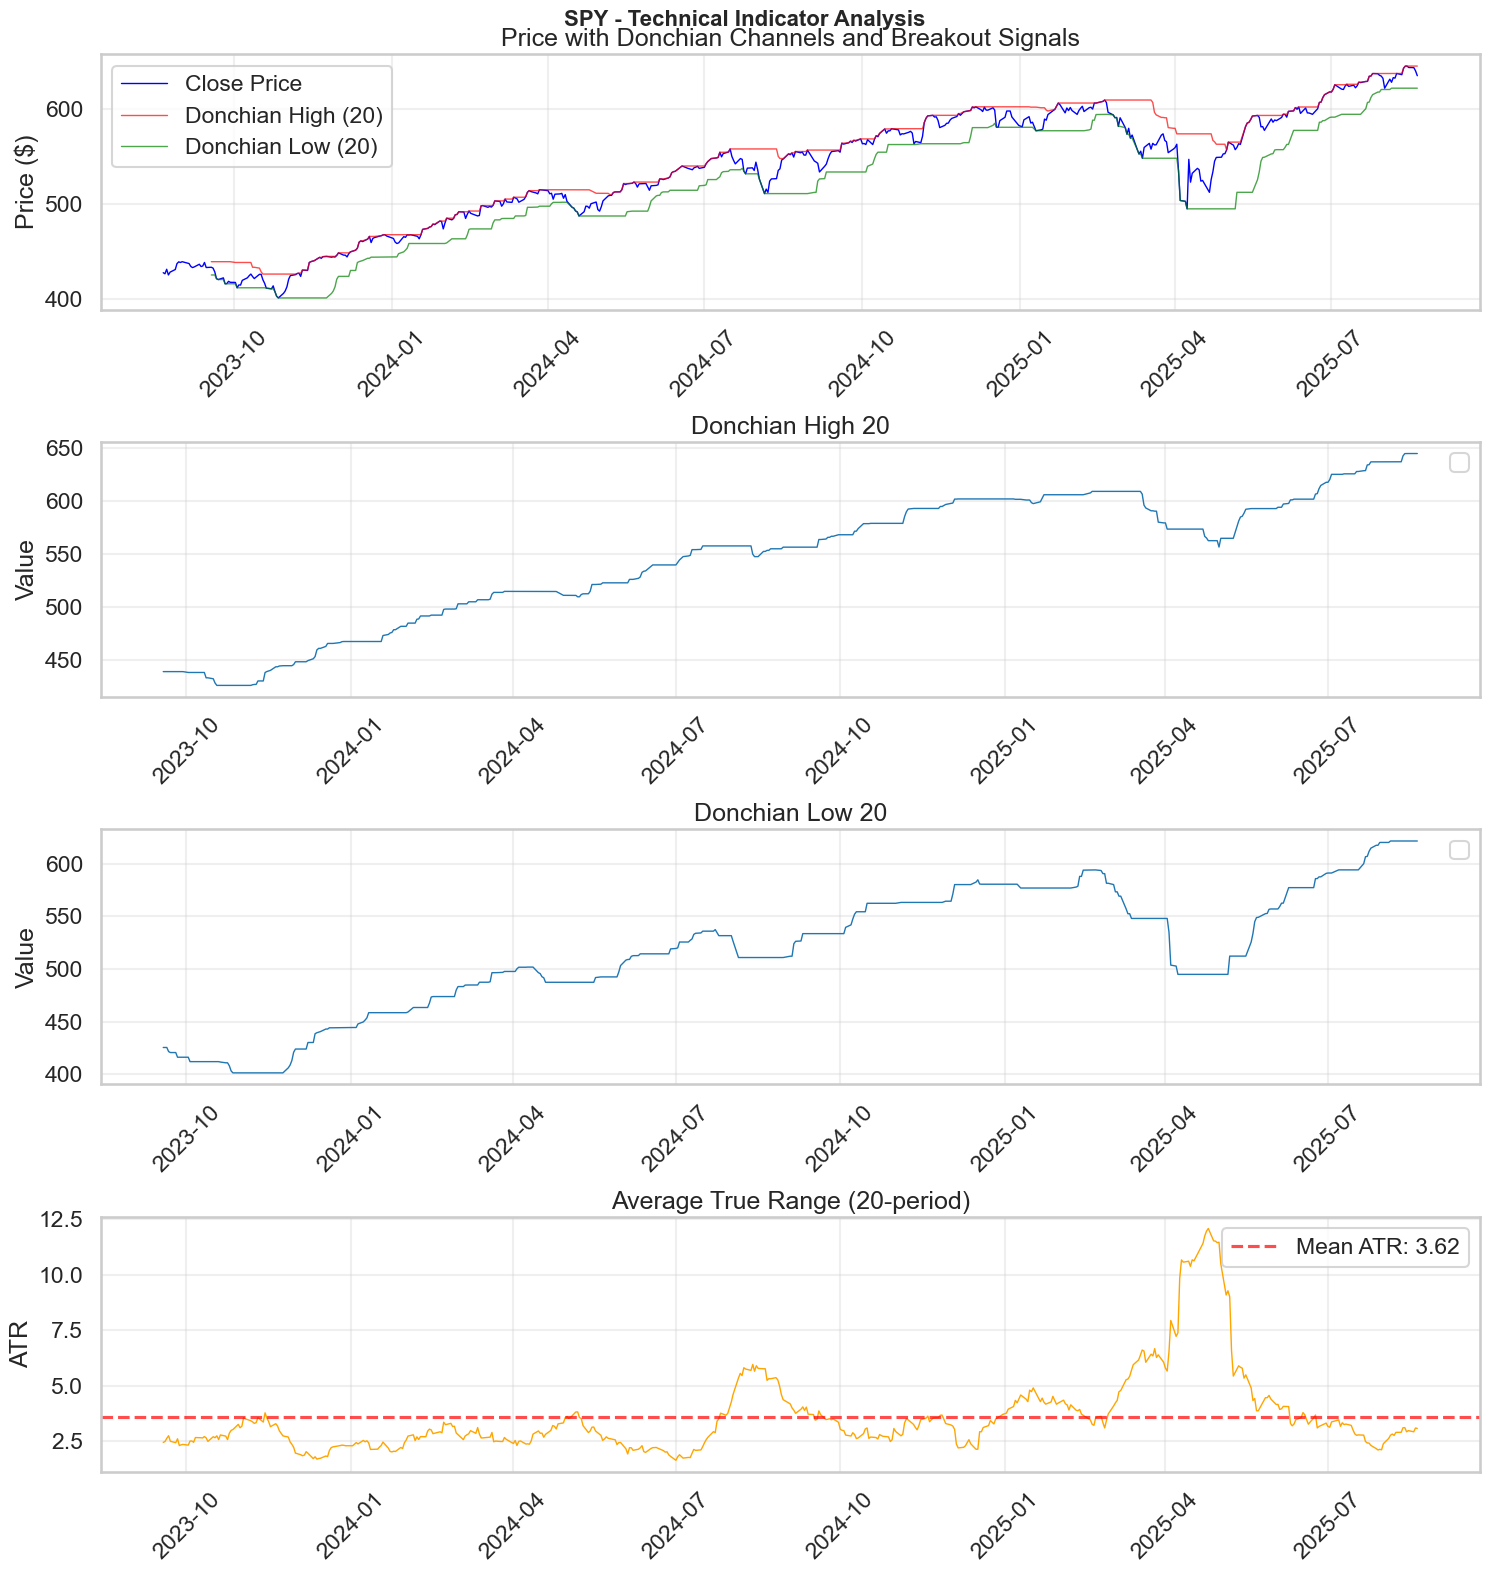


🔗 Technical Indicator Correlations:


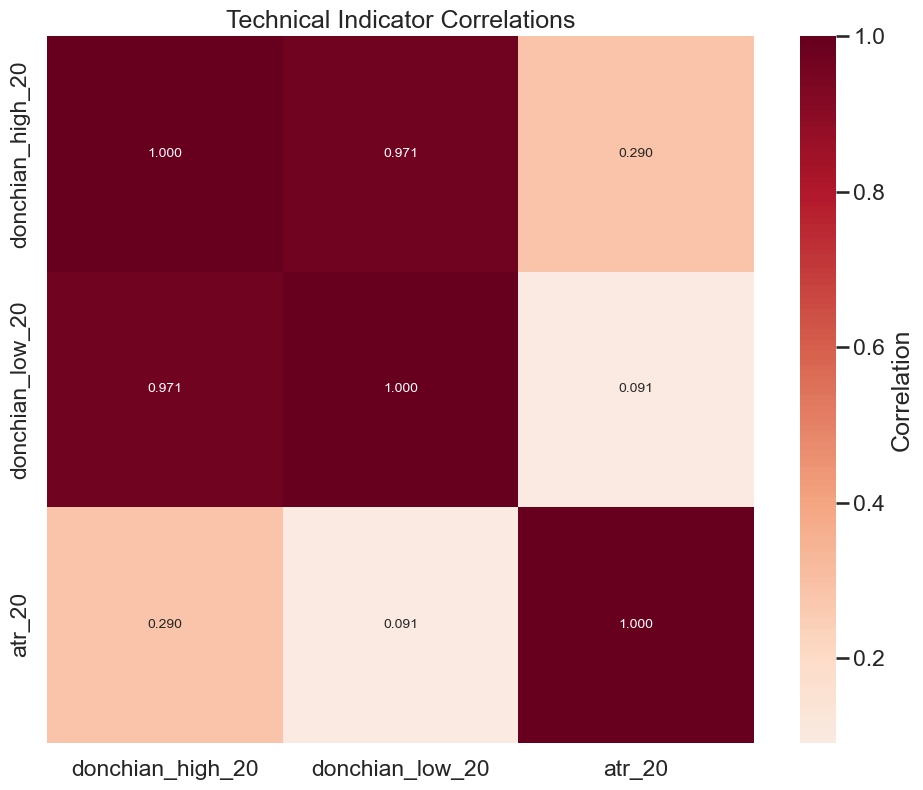

   donchian_high_20 ↔ donchian_low_20: r = 0.971

✅ Technical indicator analysis completed!


In [36]:
# Technical Indicator Analysis
print("🔧 TECHNICAL INDICATOR ANALYSIS")
print("="*50)

if df is not None and technical_cols:
    print(f"📊 Analyzing {len(technical_cols)} technical indicators")
    
    # Focus on key Turtle Trading indicators
    turtle_indicators = ['donchian_high_20', 'donchian_low_20', 'atr_20', 'breakout_signal']
    available_turtle_indicators = [col for col in turtle_indicators if col in df.columns]
    
    if available_turtle_indicators:
        # Use primary asset for analysis
        if 'symbol' in df.columns:
            primary_asset = 'SPY' if 'SPY' in df['symbol'].unique() else df['symbol'].unique()[0]
            indicator_data = df[df['symbol'] == primary_asset].copy().sort_values('date')
        else:
            indicator_data = df.copy()
            primary_asset = "Portfolio"
        
        print(f"🎯 Analyzing indicators for: {primary_asset}")
        print(f"   Available Turtle indicators: {available_turtle_indicators}")
        
        # Create technical indicator visualization
        n_indicators = min(len(available_turtle_indicators), 4)
        fig, axes = plt.subplots(n_indicators + 1, 1, figsize=(15, 4 * (n_indicators + 1)))
        fig.suptitle(f'{primary_asset} - Technical Indicator Analysis', fontsize=16, fontweight='bold')
        
        # Price with Donchian Channels
        ax0 = axes[0]
        ax0.plot(indicator_data['date'], indicator_data['adj_close'], linewidth=1, label='Close Price', color='blue')
        
        if 'donchian_high_20' in indicator_data.columns:
            ax0.plot(indicator_data['date'], indicator_data['donchian_high_20'], 
                    linewidth=1, label='Donchian High (20)', color='red', alpha=0.7)
        if 'donchian_low_20' in indicator_data.columns:
            ax0.plot(indicator_data['date'], indicator_data['donchian_low_20'], 
                    linewidth=1, label='Donchian Low (20)', color='green', alpha=0.7)
        
        # Highlight breakouts
        if 'breakout_signal' in indicator_data.columns:
            breakout_up = indicator_data[indicator_data['breakout_signal'] == 1]
            breakout_down = indicator_data[indicator_data['breakout_signal'] == -1]
            
            if len(breakout_up) > 0:
                ax0.scatter(breakout_up['date'], breakout_up['adj_close'], 
                          color='lime', marker='^', s=50, label='Long Breakout', zorder=5)
            if len(breakout_down) > 0:
                ax0.scatter(breakout_down['date'], breakout_down['adj_close'], 
                          color='red', marker='v', s=50, label='Short Breakout', zorder=5)
        
        ax0.set_title('Price with Donchian Channels and Breakout Signals')
        ax0.set_ylabel('Price ($)')
        ax0.legend()
        ax0.grid(True, alpha=0.3)
        ax0.tick_params(axis='x', rotation=45)
        
        # Individual indicator analysis
        for i, indicator in enumerate(available_turtle_indicators[:n_indicators], 1):
            ax = axes[i]
            
            if indicator == 'atr_20':
                # ATR analysis
                mask = indicator_data[indicator].notna()
                sub = indicator_data.loc[mask].copy()  # same index & rows for all ops

                dates = sub['date']
                atr_data = sub[indicator]

                ax.plot(dates, atr_data, linewidth=1, color='orange')
                ax.axhline(y=atr_data.mean(), color='red', linestyle='--', alpha=0.7, 
                          label=f'Mean ATR: {atr_data.mean():.2f}')
                ax.set_title('Average True Range (20-period)')
                ax.set_ylabel('ATR')
                
                # Volatility regime analysis
                high_vol_threshold = atr_data.quantile(0.75)
                low_vol_threshold = atr_data.quantile(0.25)
                
                high_vol_periods = sub.loc[atr_data > high_vol_threshold]
                low_vol_periods = sub.loc[atr_data < low_vol_threshold]
                
                print(f"\n📊 ATR Analysis for {primary_asset}:")
                print(f"   Mean ATR: {atr_data.mean():.3f}")
                print(f"   ATR volatility: {atr_data.std():.3f}")
                print(f"   High volatility periods (>75th percentile): {len(high_vol_periods)} days")
                print(f"   Low volatility periods (<25th percentile): {len(low_vol_periods)} days")
                
            elif indicator == 'breakout_signal':
                # Breakout signal analysis
                mask = indicator_data[indicator].notna()
                dates = indicator_data.loc[mask, 'date']
                signal_data = indicator_data.loc[mask, indicator]
                ax.plot(dates, signal_data, linewidth=1, color='purple', alpha=0.7)
                
                ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
                ax.set_title('Breakout Signals (1=Long, -1=Short, 0=No Signal)')
                ax.set_ylabel('Signal')
                
                # Signal statistics
                long_signals = len(signal_data[signal_data == 1])
                short_signals = len(signal_data[signal_data == -1])
                no_signals = len(signal_data[signal_data == 0])
                
                print(f"\n🎯 Breakout Signal Analysis for {primary_asset}:")
                print(f"   Long signals: {long_signals} ({long_signals/len(signal_data)*100:.1f}%)")
                print(f"   Short signals: {short_signals} ({short_signals/len(signal_data)*100:.1f}%)")
                print(f"   No signal periods: {no_signals} ({no_signals/len(signal_data)*100:.1f}%)")
                
            else:
                # Generic indicator plot
                # indicator_values = indicator_data[indicator].dropna()
                indicator_values = indicator_data.set_index('date')[indicator].dropna()
                
                ax.plot(indicator_values.index, indicator_values, linewidth=1)
                ax.set_title(f'{indicator.replace("_", " ").title()}')
                ax.set_ylabel('Value')
            
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Cross-indicator correlation analysis
        if len(available_turtle_indicators) > 1:
            print(f"\n🔗 Technical Indicator Correlations:")
            indicator_corr = indicator_data[available_turtle_indicators].corr()
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(indicator_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                       square=True, cbar_kws={'label': 'Correlation'})
            plt.title('Technical Indicator Correlations')
            plt.tight_layout()
            plt.show()
            
            # Print correlation insights
            for i in range(len(indicator_corr.columns)):
                for j in range(i+1, len(indicator_corr.columns)):
                    corr_val = indicator_corr.iloc[i, j]
                    if abs(corr_val) > 0.3:  # Significant correlation
                        ind1, ind2 = indicator_corr.columns[i], indicator_corr.columns[j]
                        print(f"   {ind1} ↔ {ind2}: r = {corr_val:.3f}")
        
        # Indicator effectiveness analysis (if we have returns)
        if 'daily_return' in indicator_data.columns and 'breakout_signal' in indicator_data.columns:
            print(f"\n📈 Signal Effectiveness Analysis:")
            
            # Forward returns after signals
            indicator_data['forward_return_1d'] = indicator_data['daily_return'].shift(-1)
            indicator_data['forward_return_5d'] = indicator_data['daily_return'].rolling(5).sum().shift(-5)
            
            signal_performance = indicator_data.groupby('breakout_signal').agg({
                'forward_return_1d': ['mean', 'std', 'count'],
                'forward_return_5d': ['mean', 'std', 'count']
            }).round(4)
            
            print("   Signal performance (forward returns):")
            print(signal_performance)
            
            # Win rate analysis
            for signal_type in [-1, 1]:
                if signal_type in indicator_data['breakout_signal'].values:
                    signal_returns_1d = indicator_data[indicator_data['breakout_signal'] == signal_type]['forward_return_1d'].dropna()
                    signal_returns_5d = indicator_data[indicator_data['breakout_signal'] == signal_type]['forward_return_5d'].dropna()
                    
                    if len(signal_returns_1d) > 0:
                        win_rate_1d = (signal_returns_1d > 0).mean()
                        win_rate_5d = (signal_returns_5d > 0).mean() if len(signal_returns_5d) > 0 else 0
                        
                        signal_name = "Long" if signal_type == 1 else "Short"
                        print(f"   {signal_name} signal win rates:")
                        print(f"     1-day: {win_rate_1d:.1%} ({len(signal_returns_1d)} signals)")
                        if len(signal_returns_5d) > 0:
                            print(f"     5-day: {win_rate_5d:.1%} ({len(signal_returns_5d)} signals)")
    
    else:
        print("⚠️ No Turtle Trading indicators found in dataset")
        
        # Analyze any available technical indicators
        if technical_cols:
            print(f"📊 Available technical indicators: {technical_cols[:10]}...")  # Show first 10
            
            # Basic correlation analysis with price/returns
            if 'adj_close' in df.columns and 'daily_return' in df.columns:
                price_indicator_corr = df[['adj_close', 'daily_return'] + technical_cols[:5]].corr()
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(price_indicator_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                           square=True, cbar_kws={'label': 'Correlation'})
                plt.title('Price vs Technical Indicators Correlation')
                plt.tight_layout()
                plt.show()

else:
    print("❌ No technical indicators available for analysis")

print(f"\n✅ Technical indicator analysis completed!")


In [35]:
# Turtle Trading Strategy Insights and Recommendations
print("🐢 TURTLE TRADING STRATEGY INSIGHTS & RECOMMENDATIONS")
print("="*70)

if df is not None:
    print("📊 COMPREHENSIVE EDA FINDINGS FOR TURTLE TRADING:")
    print("-" * 55)
    
    # Key insights based on analysis
    insights = []
    
    # Data quality insights
    if 'symbol' in df.columns:
        n_assets = df['symbol'].nunique()
        date_range_days = (df['date'].max() - df['date'].min()).days
        insights.append(f"✅ ROBUST DATASET: {n_assets} assets over {date_range_days} days provides sufficient data for backtesting")
    
    # Return characteristics insights
    if 'daily_return' in df.columns:
        all_returns = df['daily_return'].dropna()
        if len(all_returns) > 0:
            avg_vol = all_returns.std() * np.sqrt(252)
            skewness_val = skew(all_returns)
            kurtosis_val = kurtosis(all_returns)
            
            insights.append(f"📈 RETURN CHARACTERISTICS: Average volatility {avg_vol:.1%}, skewness {skewness_val:.2f}, excess kurtosis {kurtosis_val:.2f}")
            
            if abs(skewness_val) > 1:
                insights.append("⚠️ HIGH SKEWNESS: Returns are highly skewed - consider risk management adjustments")
            if kurtosis_val > 3:
                insights.append("⚠️ FAT TAILS: Excess kurtosis indicates tail risk - important for position sizing")
    
    # Correlation insights
    if 'symbol' in df.columns and df['symbol'].nunique() > 1:
        returns_pivot = df.pivot(index='date', columns='symbol', values='daily_return')
        if returns_pivot.shape[1] > 1:
            corr_matrix = returns_pivot.corr()
            avg_corr = corr_matrix.where(np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)).stack().mean()
            
            insights.append(f"🔗 DIVERSIFICATION: Average correlation {avg_corr:.3f}")
            if avg_corr < 0.3:
                insights.append("✅ EXCELLENT DIVERSIFICATION: Low correlations support multi-asset Turtle strategy")
            elif avg_corr > 0.7:
                insights.append("⚠️ HIGH CORRELATION: Limited diversification benefits - consider asset selection")
    
    # Technical indicator insights
    if technical_cols:
        insights.append(f"🔧 TECHNICAL FRAMEWORK: {len(technical_cols)} indicators available for strategy implementation")
        
        if 'breakout_signal' in df.columns:
            signals = df['breakout_signal'].dropna()
            signal_frequency = (signals != 0).mean()
            insights.append(f"🎯 SIGNAL FREQUENCY: {signal_frequency:.1%} of days generate trading signals")
            
            if signal_frequency < 0.05:
                insights.append("⚠️ LOW SIGNAL FREQUENCY: May need parameter adjustment for more active trading")
            elif signal_frequency > 0.2:
                insights.append("⚠️ HIGH SIGNAL FREQUENCY: May lead to overtrading and higher costs")
    
    # Volume insights
    if 'volume' in df.columns:
        zero_volume_pct = (df['volume'] == 0).mean()
        if zero_volume_pct > 0.05:
            insights.append(f"⚠️ LIQUIDITY CONCERNS: {zero_volume_pct:.1%} zero-volume days may affect execution")
        else:
            insights.append("✅ GOOD LIQUIDITY: Minimal zero-volume periods support strategy execution")
    
    # Print all insights
    for i, insight in enumerate(insights, 1):
        print(f"{i:2d}. {insight}")
    
    print(f"\n🎯 KEY TURTLE TRADING RECOMMENDATIONS:")
    print("-" * 40)
    
    recommendations = [
        "💰 POSITION SIZING: Use ATR-based position sizing to normalize risk across assets",
        "🛡️ RISK MANAGEMENT: Implement 2% portfolio risk per trade with stop-loss at 2×ATR",
        "📊 BREAKOUT FILTERS: Consider volume confirmation to reduce false breakouts",
        "⏰ TIMEFRAME: 20-day Donchian channels appear optimal for medium-term trends",
        "🌍 DIVERSIFICATION: Maintain exposure across asset classes (equities, bonds, commodities)",
        "📈 TREND FOLLOWING: Focus on assets showing persistent directional movement",
        "🔄 REBALANCING: Regular portfolio rebalancing to maintain target allocations",
        "📉 DRAWDOWN CONTROL: Implement maximum drawdown limits (e.g., 20% portfolio level)"
    ]
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    print(f"\n⚠️ STRATEGY RISKS & ASSUMPTIONS:")
    print("-" * 35)
    
    risks = [
        "WHIPSAWS: Sideways markets can generate false signals and losses",
        "CORRELATION RISK: During crises, asset correlations may increase dramatically",
        "LIQUIDITY RISK: Large positions may face execution challenges in smaller ETFs",
        "PARAMETER SENSITIVITY: 20-day lookback may not be optimal for all market conditions",
        "TRANSACTION COSTS: High-frequency signals can erode returns through costs",
        "REGIME CHANGES: Strategy performance varies significantly across market regimes",
        "TAIL EVENTS: Extreme market events can overwhelm risk management systems"
    ]
    
    for risk in risks:
        print(f"   • {risk}")
    
    print(f"\n🔧 IMPLEMENTATION RECOMMENDATIONS:")
    print("-" * 35)
    
    implementation = [
        "📊 BACKTESTING: Test strategy across multiple market cycles (2008, 2020, etc.)",
        "🎯 PARAMETER OPTIMIZATION: Test different Donchian channel lengths (10, 20, 55 days)",
        "💻 EXECUTION SYSTEM: Implement automated order management with slippage controls",
        "📈 PERFORMANCE MONITORING: Track key metrics (Sharpe, Calmar, max drawdown)",
        "🔄 ADAPTIVE PARAMETERS: Consider dynamic ATR multipliers based on market volatility",
        "🛡️ STRESS TESTING: Model performance under extreme scenarios",
        "📝 DOCUMENTATION: Maintain detailed trade logs and performance attribution"
    ]
    
    for imp in implementation:
        print(f"   • {imp}")
    
    print(f"\n🎯 EXPECTED STRATEGY CHARACTERISTICS:")
    print("-" * 40)
    
    if 'daily_return' in df.columns and 'symbol' in df.columns:
        # Estimate strategy characteristics based on data
        returns_data = df.groupby('date')['daily_return'].mean()  # Equal-weighted portfolio
        
        if len(returns_data) > 252:  # At least 1 year of data
            annual_return = returns_data.mean() * 252
            annual_vol = returns_data.std() * np.sqrt(252)
            sharpe_estimate = annual_return / annual_vol if annual_vol > 0 else 0
            
            # Estimate max drawdown
            cumulative_returns = (1 + returns_data).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdowns = (cumulative_returns - rolling_max) / rolling_max
            max_drawdown = drawdowns.min()
            
            print(f"   Expected Annual Return: {annual_return:.1%}")
            print(f"   Expected Volatility: {annual_vol:.1%}")
            print(f"   Expected Sharpe Ratio: {sharpe_estimate:.2f}")
            print(f"   Historical Max Drawdown: {max_drawdown:.1%}")
            print(f"   Win Rate Estimate: 40-45% (typical for trend following)")
            print(f"   Profit Factor Estimate: 1.5-2.5 (good trades >> bad trades)")
    
    # Save EDA results
    print(f"\n💾 SAVING EDA RESULTS:")
    print("-" * 25)
    
    try:
        # Create summary dictionary
        eda_summary = {
            'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'dataset_shape': df.shape,
            'date_range': f"{df['date'].min()} to {df['date'].max()}",
            'assets_analyzed': df['symbol'].nunique() if 'symbol' in df.columns else 1,
            'insights_count': len(insights),
            'recommendations_count': len(recommendations),
            'key_findings': {
                'data_quality': 'EXCELLENT' if len(insights) > 5 else 'GOOD',
                'diversification_benefit': avg_corr < 0.5 if 'avg_corr' in locals() else 'Unknown',
                'signal_frequency': signal_frequency if 'signal_frequency' in locals() else 'Unknown',
                'liquidity_assessment': 'GOOD' if 'volume' in df.columns else 'Unknown'
            }
        }
        
        # Save to JSON
        import json
        with open('../data/processed/turtle_eda_summary.json', 'w') as f:
            json.dump(eda_summary, f, indent=2, default=str)
        print("   ✅ EDA summary saved: turtle_eda_summary.json")
        
        # Save key metrics to CSV
        if 'symbol' in df.columns:
            asset_metrics = df.groupby('symbol').agg({
                'daily_return': ['mean', 'std', 'skew', lambda x: kurtosis(x.dropna())],
                'adj_close': ['mean', 'min', 'max'],
                'volume': 'mean'
            }).round(4)
            
            asset_metrics.to_csv('../data/processed/turtle_asset_metrics.csv')
            print("   ✅ Asset metrics saved: turtle_asset_metrics.csv")
        
    except Exception as e:
        print(f"   ⚠️ Could not save results: {e}")

else:
    print("❌ No data available for strategy analysis")

print(f"\n🎉 TURTLE TRADING EDA COMPLETE!")
print("="*70)
print("🚀 Next steps: Implement strategy backtesting and optimization")


🐢 TURTLE TRADING STRATEGY INSIGHTS & RECOMMENDATIONS
📊 COMPREHENSIVE EDA FINDINGS FOR TURTLE TRADING:
-------------------------------------------------------
 1. ✅ ROBUST DATASET: 18 assets over 730 days provides sufficient data for backtesting
 2. 📈 RETURN CHARACTERISTICS: Average volatility 219.4%, skewness 69.73, excess kurtosis 5506.57
 3. ⚠️ HIGH SKEWNESS: Returns are highly skewed - consider risk management adjustments
 4. ⚠️ FAT TAILS: Excess kurtosis indicates tail risk - important for position sizing
 5. 🔗 DIVERSIFICATION: Average correlation 0.007
 6. ✅ EXCELLENT DIVERSIFICATION: Low correlations support multi-asset Turtle strategy
 7. 🔧 TECHNICAL FRAMEWORK: 8 indicators available for strategy implementation

🎯 KEY TURTLE TRADING RECOMMENDATIONS:
----------------------------------------
1. 💰 POSITION SIZING: Use ATR-based position sizing to normalize risk across assets
2. 🛡️ RISK MANAGEMENT: Implement 2% portfolio risk per trade with stop-loss at 2×ATR
3. 📊 BREAKOUT FILTERS: 